<a href="https://colab.research.google.com/github/gerritschoe/sonnet/blob/v2/examples/TF2_VQ_VAE_for_brain_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE training example

Demonstration of how to train the model specified in https://arxiv.org/abs/1711.00937, using TF 2 / Sonnet 2.

On Mac and Linux, simply execute each cell in turn.

First half of the Code is copied from https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb (Apache v2 License, https://github.com/deepmind/sonnet/blob/v2/LICENSE)


Good explanation of VQ-VAE-2: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html



Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [0]:
# show us what GPU we are using 
!nvidia-smi

# P100 is best
# T4, P4 are medium
# K80 ist worst
# restart notebook to maybe get a better gpu (assignment is random)

Fri May 22 20:27:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install dm-sonnet dm-tree

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.2.0
Sonnet version 2.0.0


# Download Cifar10 data
This requires a connection to the internet and will download ~160MB.


In [0]:
cifar10 = tfds.as_numpy(tfds.load("cifar10:3.0.0", split="train+test", batch_size=-1))
cifar10.pop("id", None)
cifar10.pop("label")
tree.map_structure(lambda x: f'{x.dtype.name}{list(x.shape)}', cifar10)

{'image': 'uint8[60000, 32, 32, 3]'}

# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [0]:
train_data_dict = tree.map_structure(lambda x: x[:40000], cifar10)
valid_data_dict = tree.map_structure(lambda x: x[40000:50000], cifar10)
test_data_dict = tree.map_structure(lambda x: x[50000:], cifar10)

In [0]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  images = data_dict['image']
  data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

train_data_variance = np.var(train_data_dict['image'] / 255.0)
print('train data variance: %s' % train_data_variance)
print('Number of images:', len(train_data_dict['image']))
print('Size of an image:', len(train_data_dict['image'][0].shape))

train data variance: 0.06327039811675479
Number of images: 40000
Size of an image: 3


# Encoder & Decoder Architecture


In [0]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")
    
  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon
    

class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

# Build Model and train

In [0]:
%%time

# Set hyper-parameters.
batch_size = 32 
image_size = 32 # increase to 256 in the future (need high-resolution dataset like ImageNet)

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data['image'], is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []


CPU times: user 84.3 ms, sys: 2.91 ms, total: 87.2 ms
Wall time: 87.7 ms


In [0]:
# train
%%time
for step_index, data in enumerate(train_dataset):
  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f167fcceea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f167fcceea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f167fcceea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


100 train loss: 0.527368 recon_error: 0.489 perplexity: 8.781 vqvae loss: 0.038
200 train loss: 0.279882 recon_error: 0.254 perplexity: 16.072 vqvae loss: 0.026
300 train loss: 0.219680 recon_error: 0.195 perplexity: 21.498 vqvae loss: 0.025
400 train loss: 0.203056 recon_error: 0.180 perplexity: 26.804 vqvae loss: 0.023
500 train loss: 0.186419 recon_error: 0.158 perplexity: 33.619 vqvae loss: 0.028
600 train loss: 0.170726 recon_error: 0.142 perplexity: 40.512 vqvae loss: 0.029
700 train loss: 0.159131 recon_error: 0.129 perplexity: 47.944 vqvae loss: 0.030
800 train loss: 0.148832 recon_error: 0.120 perplexity: 55.793 vqvae loss: 0.029
900 train loss: 0.140492 recon_error: 0.113 perplexity: 64.330 vqvae loss: 0.028
1000 train loss: 0.135695 recon_error: 0.108 perplexity: 72.464 vqvae loss: 0.027
1100 train loss: 0.128715 recon_error: 0.102 perplexity: 80.170 vqvae loss: 0.026
1200 train loss: 0.125159 recon_error: 0.099 perplexity: 90.366 vqvae loss: 0.027
1300 train loss: 0.123005 

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

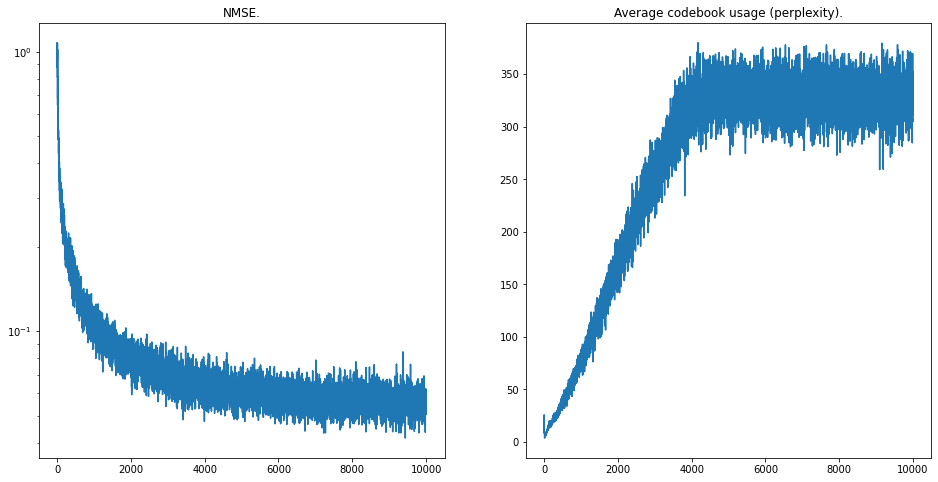

In [0]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

(-0.5, 255.5, 127.5, -0.5)

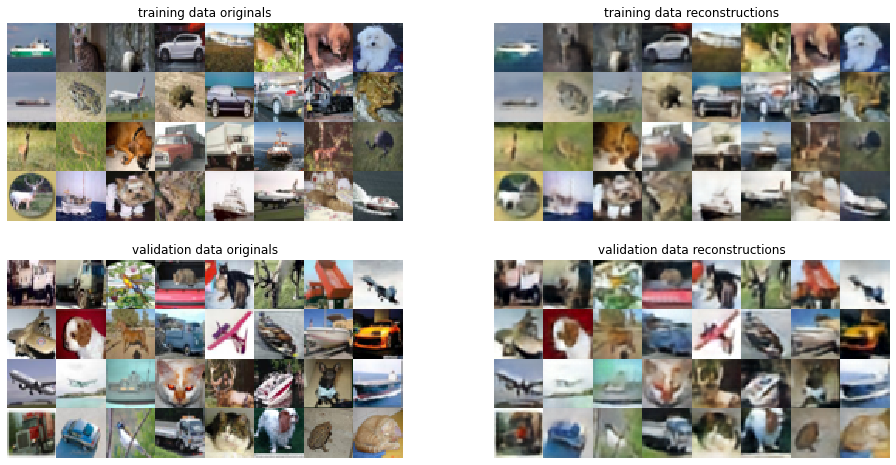

In [0]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch['image'],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch['image'],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')


# Download Brain images dataset from Kaggle 
Data source: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

In [0]:
# download data
!wget -O data.zip --no-check-certificate "https://drive.google.com/uc?id=1pCh8tRYORiPlbIcqDEPmN9u37Q8xmqej&export=download"

--2020-05-22 20:33:56--  https://drive.google.com/uc?id=1pCh8tRYORiPlbIcqDEPmN9u37Q8xmqej&export=download
Resolving drive.google.com (drive.google.com)... 108.177.126.101, 108.177.126.100, 108.177.126.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f9hpm0333pqdpbcovfag4s84mkdi3c1n/1590179625000/05468793335762875079/*/1pCh8tRYORiPlbIcqDEPmN9u37Q8xmqej?e=download [following]
--2020-05-22 20:33:57--  https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f9hpm0333pqdpbcovfag4s84mkdi3c1n/1590179625000/05468793335762875079/*/1pCh8tRYORiPlbIcqDEPmN9u37Q8xmqej?e=download
Resolving doc-0g-c0-docs.googleusercontent.com (doc-0g-c0-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-0g-c0-docs.googleusercontent.com (d

In [0]:
# remove data directory if exist 
!rm -r data

In [0]:
# unzip new data
%%capture
!unzip data.zip -d data
print('Done')

In [0]:
import os, sys
from PIL import Image

size = 32, 32                 # 256, 256 in the future (need to retrain VAE)
!rm -r /content/resized_imgs
!mkdir /content/resized_imgs
!mkdir /content/resized_imgs/yes
!mkdir /content/resized_imgs/no

for su filename in files:
     bdir, dirs, files in os.walk(r'/content/data/brain_tumor_dataset'):
  for filepath = subdir + os.sep + filename
      outfile = '/content/resized_imgs/' + subdir.split('/')[-1] + '/' + filename
      try:
          im = Image.open(filepath)
          im.thumbnail(size, Image.ANTIALIAS)
          old_size = im.size
          new_size = (size)
          new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
          new_im.paste(im, ((new_size[0]-old_size[0])//2,
                                (new_size[1]-old_size[1])//2))
          new_im.save(outfile, "JPEG")
      except IOError:
          print("cannot create thumbnail for '%s'" % filepath)

# Use the trained VAE with brain tumor images
Resolution of images is (32,32), but the VAE could easily be retrained for (256,256) with the ImageNet dataset instead of Cifar10

In [0]:
# create custom dataset from loaded images
custom_data_dict_yes = {}
custom_data_dict_yes['image'] = []
custom_data_dict_no = {}
custom_data_dict_no['image'] = []

for subdir, dirs, files in os.walk(r'/content/resized_imgs/no'):
  for filename in files:
      filepath = subdir + os.sep + filename
      try:
          im = Image.open(filepath)
          custom_data_dict_no['image'].append(np.array(im))
      except: 
        print('couldnt create numpy version of', filepath)

for subdir, dirs, files in os.walk(r'/content/resized_imgs/yes'):
  for filename in files:
      filepath = subdir + os.sep + filename
      try:
          im = Image.open(filepath)
          custom_data_dict_yes['image'].append(np.array(im))
      except: 
        print('couldnt create numpy version of', filepath)

custom_dataset_no = (
    tf.data.Dataset.from_tensor_slices(custom_data_dict_no)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(98) # adjustyed batchsize
    .prefetch(-1))

custom_dataset_yes = (
    tf.data.Dataset.from_tensor_slices(custom_data_dict_yes)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(98) # adjustyed batchsize
    .prefetch(-1))

(-0.5, 255.5, 127.5, -0.5)

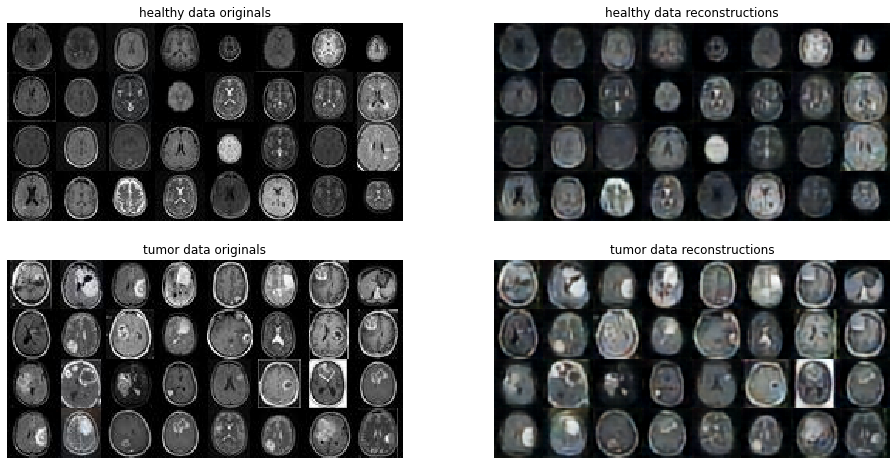

In [0]:
# Reconstructions
train_batch = next(iter(custom_dataset_no))
valid_batch = next(iter(custom_dataset_yes))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions_ = model(train_batch['image'],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions_ = model(valid_batch['image'],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5


f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['image'][:32].numpy()),
          interpolation='nearest')
ax.set_title('healthy data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions_[:32]),
          interpolation='nearest')
ax.set_title('healthy data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['image'][:32].numpy()),
          interpolation='nearest')
ax.set_title('tumor data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions_[:32]),
          interpolation='nearest')
ax.set_title('tumor data reconstructions')
plt.axis('off')

In [0]:
# Adjusted Reconstructions
train_batch = next(iter(custom_dataset_no))
valid_batch = next(iter(custom_dataset_yes))
train_reconstructions = model(train_batch['image'],
                              is_training=False)
valid_reconstructions = model(valid_batch['image'],
                              is_training=False)

print(train_reconstructions.keys()) # dict_keys(['z', 'x_recon', 'loss', 'recon_error', 'vq_output'])
print(valid_reconstructions.keys()) # dict_keys(['z', 'x_recon', 'loss', 'recon_error', 'vq_output'])
print(train_reconstructions['z'].shape) # (32, 8, 8, 64), 32 images

print(train_reconstructions['z'][0].shape) # (8, 8, 64), image divided in 8x8 cells, each with 64 latent variables
print(train_reconstructions['z'][0][0][0])

all_latent = tf.reshape(
    train_reconstructions['z'][0], 8*8*64, name=None
)
print(all_latent.shape)

yes_latent = []
for e in train_reconstructions['z']:
  avg = []
  for i in range(8):
    for j in range(8):
      lat = e[i][j]
      avg.append(lat) 
  yes_latent.append(tf.reduce_mean(avg, 0)) # axis = 0
print(len(yes_latent))
no_latent = []
for e in valid_reconstructions['z']:
  avg = []
  for i in range(8):
    for j in range(8):
      lat = e[i][j]
      avg.append(lat) 
  no_latent.append(tf.reduce_mean(avg, 0))
print(len(no_latent))
print('Done')

dict_keys(['z', 'x_recon', 'loss', 'recon_error', 'vq_output'])
dict_keys(['z', 'x_recon', 'loss', 'recon_error', 'vq_output'])
(98, 8, 8, 64)
(8, 8, 64)
tf.Tensor(
[-3.483498   -1.4755006   1.654324   -5.0589056  -0.3319373   1.8589662
  3.5964308  -0.40944436  0.5308182   4.0045176   3.0012853  -0.37922922
  0.47719336 -2.8512187  -1.1230899   1.665922   -0.55623114  0.0089156
  0.93497384 -4.169326   -0.25445032 -2.0787604   1.4732769  -1.5282475
 -1.6368858   3.4979084  -2.789095    1.892869   -5.9427543  -2.4521878
 -0.7404147  -0.40405965 -3.1978085  -1.4952903   2.5796716   0.49830148
 -0.09934708 -0.56016004  0.8724206  -2.4417448   0.7163317  -1.0100514
  0.45964283 -0.8048553  -2.6340337   2.7965956   0.88881165 -0.89280105
 -2.7420442  -0.44976017  1.3849995   2.1531947   1.18219     0.12305632
 -4.351131   -2.0425143   1.2607083  -1.5633211  -2.1025984   2.3712618
  1.0334457   4.856346    0.7640046   3.9011755 ], shape=(64,), dtype=float32)
(4096,)
98
98
Done


# Create SVM to distingluish yes_latent and no_latent

Result: DICE score of 0.64 beats best results in https://arxiv.org/pdf/1804.04488.pdf

In [0]:
from sklearn import svm
X = np.vstack([no_latent, yes_latent])
print(X.shape)
y =  np.hstack([np.zeros(len(no_latent)), np.ones(len(yes_latent))])
print(y.shape)
clf = svm.SVC()
clf.fit(X, y)

(196, 64)
(196,)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
print('test')
print(clf.predict([no_latent[0]]))
print(clf.predict([yes_latent[0]]))

test
[0.]
[1.]


In [0]:
from sklearn.model_selection import cross_val_score
print('DICE:')
score = cross_val_score(clf, X, y, cv=5, scoring='f1') #'roc_auc', 'accuracy', 'f1'
print(score)
print('mean', np.mean(score))
# more metrices: https://scikit-learn.org/stable/modules/model_evaluation.html
# f1 = DICE
# Compare results to Table 1 in https://arxiv.org/pdf/1804.04488.pdf

DICE:
[0.73170732 0.7027027  0.52631579 0.65116279 0.55813953]
mean 0.6340056269661906


# One-class SVM for anomaly detection
https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c

Result: Didn't actually work well

In [0]:
from sklearn.svm import OneClassSVM
X = no_latent
clf = OneClassSVM(gamma='auto').fit(X)
print(clf.predict(X))

X2 = yes_latent
print(clf.predict(X2))

In [0]:
from sklearn.svm import OneClassSVM 
train_normal = no_latent
train_outliers = yes_latent[:20]
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.00001) 
svm.fit(train_normal)

print(svm.predict(train_normal))
print(svm.predict(train_outliers))